## 1.简要介绍

在计算机视觉领域，图像分割指的是将数字图像细分为多个图像子区域的过程。图像分割的目的是简化或改变图像的表示形式，使得图像更容易理解和分析。图像分割通常用于定位图像中的物体和边界（线，曲线等）。更精确的，图像分割是对图像中的每个像素加标签的一个过程，这一过程使得具有相同标签的像素具有某种共同视觉特性。图像分割的领域非常多，无人车、地块检测、表计识别等等。

本示例简要介绍如何通过飞桨开源框架，实现图像分割。这里我们介绍一个在图像分割领域比较熟知的网络结构DeeplabV3 PLUS，deeplabv3 plus是deeplab系列语义分割神经网络的最终版本，在许多图像语义分割的数据集上，该网络结构都有不俗的性能表现，该网络结构中包含空洞卷积，aspp结构，encoder-decoder架构等相关知识，接下来会给大家一步步搭建deeplabv3 plus。

## 2.环境设置

导入一些比较基础常用的模块，确认自己的飞桨版本。

In [1]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PilImage

import paddle
from paddle.nn import functional as F

paddle.set_device('gpu')
paddle.__version__

'2.5.2'

## 3.数据集

### 3.1 数据集下载

本案例使用Oxford-IIIT Pet数据集，官网：https://www.robots.ox.ac.uk/~vgg/data/pets 。

数据集统计如下：

![alt 数据集统计信息](https://www.robots.ox.ac.uk/~vgg/data/pets/breed_count.jpg)

数据集包含两个压缩文件：

1. 原图：https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
2. 分割图像：https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [2]:
!tar -xf data/images.tar.gz
!tar -xf data/annotations.tar.gz

活动代码页: 936
活动代码页: 936


### 3.2 数据集概览

首先我们先看看下载到磁盘上的文件结构是什么样，来了解一下我们的数据集。

1. 首先看一下images.tar.gz这个压缩包，该文件解压后得到一个images目录，这个目录比较简单，里面直接放的是用类名和序号命名好的图片文件，每个图片是对应的宠物照片。

```bash
.
├── samoyed_7.jpg
├── ......
└── samoyed_81.jpg
```

2. 然后我们在看下annotations.tar.gz，文件解压后的目录里面包含以下内容，目录中的README文件将每个目录和文件做了比较详细的介绍，我们可以通过README来查看每个目录文件的说明。

```bash
.
├── README
├── list.txt
├── test.txt
├── trainval.txt
├── trimaps
│    ├── Abyssinian_1.png
│    ├── Abyssinian_10.png
│    ├── ......
│    └── yorkshire_terrier_99.png
└── xmls
      ├── Abyssinian_1.xml
      ├── Abyssinian_10.xml
      ├── ......
      └── yorkshire_terrier_190.xml
```

本次我们主要使用到images和annotations/trimaps两个目录，即原图和三元图像文件，前者作为训练的输入数据，后者是对应的标签数据。

我们来看看这个数据集给我们提供了多少个训练样本。

In [3]:
IMAGE_SIZE = (160, 160)
train_images_path = "images/"
label_images_path = "annotations/trimaps/"
image_count = len([os.path.join(train_images_path, image_name) 
          for image_name in os.listdir(train_images_path) 
          if image_name.endswith('.jpg')])
print("用于训练的图片样本数量:", image_count)

# 对数据集进行处理，划分训练集、测试集
def _sort_images(image_dir, image_type):
    """
    对文件夹内的图像进行按照文件名排序
    """
    files = []

    for image_name in os.listdir(image_dir):
        if image_name.endswith('.{}'.format(image_type)) \
                and not image_name.startswith('.'):
            files.append(os.path.join(image_dir, image_name))

    return sorted(files)

def write_file(mode, images, labels):
    with open('./{}.txt'.format(mode), 'w') as f:
        for i in range(len(images)):
            f.write('{}\t{}\n'.format(images[i], labels[i]))
    
"""
由于所有文件都是散落在文件夹中，在训练时我们需要使用的是数据集和标签对应的数据关系，
所以我们第一步是对原始的数据集进行整理，得到数据集和标签两个数组，分别一一对应。
这样可以在使用的时候能够很方便的找到原始数据和标签的对应关系，否则对于原有的文件夹图片数据无法直接应用。
在这里是用了一个非常简单的方法，按照文件名称进行排序。
因为刚好数据和标签的文件名是按照这个逻辑制作的，名字都一样，只有扩展名不一样。
"""
images = _sort_images(train_images_path, 'jpg')
labels = _sort_images(label_images_path, 'png')
eval_num = int(image_count * 0.15)

write_file('train', images[:-eval_num], labels[:-eval_num])
write_file('test', images[-eval_num:], labels[-eval_num:])
write_file('predict', images[-eval_num:], labels[-eval_num:])

用于训练的图片样本数量: 7390


### 3.3 PetDataSet数据集抽样展示

划分好数据集之后，我们来查验一下数据集是否符合预期，我们通过划分的配置文件读取图片路径后再加载图片数据来用matplotlib进行展示，这里要注意的是对于分割的标签文件因为是1通道的灰度图片，需要在使用imshow接口时注意下传参cmap='gray'。

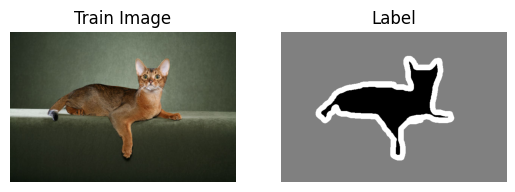

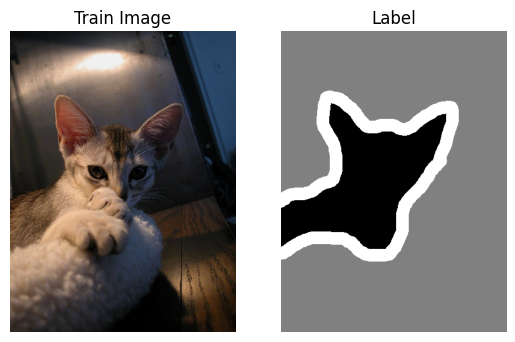

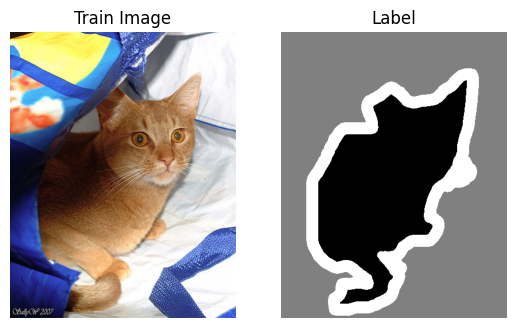

In [4]:
with open('./train.txt', 'r') as f:
    i = 0

    for line in f.readlines():
        image_path, label_path = line.strip().split('\t')
        image = np.array(PilImage.open(image_path))
        label = np.array(PilImage.open(label_path))
    
        if i > 2:
            break
        # 进行图片的展示
        plt.figure()

        plt.subplot(1,2,1), 
        plt.title('Train Image')
        plt.imshow(image.astype('uint8'))
        plt.axis('off')

        plt.subplot(1,2,2), 
        plt.title('Label')
        plt.imshow(label.astype('uint8'), cmap='gray')
        plt.axis('off')

        plt.show()
        i = i + 1

### 3.4 数据集类定义

飞桨（PaddlePaddle）数据集加载方案是统一使用Dataset（数据集定义） + DataLoader（多进程数据集加载）。

首先我们先进行数据集的定义，数据集定义主要是实现一个新的Dataset类，继承父类paddle.io.Dataset，并实现父类中以下两个抽象方法，`__getitem__`和`__len__`：

```python
class MyDataset(Dataset):
    def __init__(self):
        ...
        
    # 每次迭代时返回数据和对应的标签
    def __getitem__(self, idx):
        return x, y

    # 返回整个数据集的总数
    def __len__(self):
        return count(samples)
```

在数据集内部可以结合图像数据预处理相关API进行图像的预处理（改变大小、反转、调整格式等）。

由于加载进来的图像不一定都符合自己的需求，举个例子，已下载的这些图片里面就会有RGBA格式的图片，这个时候图片就不符合我们所需3通道的需求，我们需要进行图片的格式转换，那么这里我们直接实现了一个通用的图片读取接口，确保读取出来的图片都是满足我们的需求。

另外图片加载出来的默认shape是HWC，这个时候要看看是否满足后面训练的需要，如果Layer的默认格式和这个不是符合的情况下，需要看下Layer有没有参数可以进行格式调整。不过如果layer较多的话，还是直接调整原数据Shape比较好，否则每个layer都要做参数设置，如果有遗漏就会导致训练出错，那么在本案例中是直接对数据源的shape做了统一调整，从HWC转换成了CHW，因为飞桨的卷积等API的默认输入格式为CHW，这样处理方便后续模型训练。

In [5]:
import random

from paddle.io import Dataset
from paddle.vision.transforms import transforms as T


class PetDataset(Dataset):
    """
    数据集定义
    """
    def __init__(self, mode='train'):
        """
        构造函数
        """
        self.image_size = IMAGE_SIZE
        self.mode = mode.lower()
        
        assert self.mode in ['train', 'test', 'predict'], \
            "mode should be 'train' or 'test' or 'predict', but got {}".format(self.mode)
        
        self.train_images = []
        self.label_images = []

        with open('./{}.txt'.format(self.mode), 'r') as f:
            for line in f.readlines():
                image, label = line.strip().split('\t')
                self.train_images.append(image)
                self.label_images.append(label)
        
    def _load_img(self, path, color_mode='rgb', transforms=[]):
        """
        统一的图像处理接口封装，用于规整图像大小和通道
        """
        with open(path, 'rb') as f:
            img = PilImage.open(io.BytesIO(f.read()))
            if color_mode == 'grayscale':
                # if image is not already an 8-bit, 16-bit or 32-bit grayscale image
                # convert it to an 8-bit grayscale image.
                if img.mode not in ('L', 'I;16', 'I'):
                    img = img.convert('L')
            elif color_mode == 'rgba':
                if img.mode != 'RGBA':
                    img = img.convert('RGBA')
            elif color_mode == 'rgb':
                if img.mode != 'RGB':
                    img = img.convert('RGB')
            else:
                raise ValueError('color_mode must be "grayscale", "rgb", or "rgba"')
            
            return T.Compose([
                T.Resize(self.image_size)
            ] + transforms)(img)

    def __getitem__(self, idx):
        """
        返回 image, label
        """
        train_image = self._load_img(self.train_images[idx], 
                                     transforms=[
                                         T.Transpose(), 
                                         T.Normalize(mean=127.5, std=127.5)
                                     ]) # 加载原始图像
        label_image = self._load_img(self.label_images[idx], 
                                     color_mode='grayscale',
                                     transforms=[T.Grayscale()]) # 加载Label图像
    
        # 返回image, label
        train_image = np.array(train_image, dtype='float32')
        label_image = np.array(label_image, dtype='int64')
        return train_image, label_image
        
    def __len__(self):
        """
        返回数据集总数
        """
        return len(self.train_images)

## 4.模型组网

Deeplabv3 plus从整体结构上看可以分为编码器（encoder）与解码器（decoder）两个大块组成，如下图所示。其中encoder的部分，是一个backbone通常可以采用resnet,Xception等分类任务中常用的网络结构来做编码器，backbone最后一层输出的feature map输入aspp结构，aspp结构由不同ratio的空洞卷积核组成，不同的ratio代表不同大小的感受野，也就可以抽取不同尺度的图片信息，将所有空洞卷积处理后的feature map进行concat并采用1×1 conv降维，最终得到的语义信息丰富的特征图传递给解码器，同时为了更好地补足空洞卷积之前的信息，将backbone输出的feature map也传递给了解码器。解码器部分可以看到将低层的feature map（含有更多的图像底层信息）作为输入，首先做一个卷积操作实现维度的变换，目的是为了和4倍上采样后的aspp处理后的feature map进行concat，整个思想类似于残差结构，最终concat的结果4倍上采样到原来输入图像的尺寸并保留预测类别数目的通道数即可完成建模。


![](https://ai-studio-static-online.cdn.bcebos.com/cc9ee318edeb4814a021c404cb321896661d8f2fb638433bb428c5939022f62e)


In [6]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PilImage


from collections import OrderedDict

_BOTTLENECK_EXPANSION = 4

class _ConvBnReLU(paddle.nn.Sequential):
    """
    Cascade of 2D convolution, batch norm, and ReLU.
    """

    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, dilation, relu=True):
        super(_ConvBnReLU, self).__init__()
        self.conv_1 = paddle.nn.Conv2D(in_ch, out_ch, kernel_size, stride, padding, dilation)
        self.bn = paddle.nn.BatchNorm2D(out_ch, epsilon=1e-5, momentum=0.999)
        if relu:
            self.relu = paddle.nn.ReLU()

In [7]:
class _ASPP(paddle.nn.Layer):
    """
    Atrous spatial pyramid pooling with image-level feature
    """
    
    def __init__(self, in_ch, out_ch, rates):
        self.dilated_result = []
        super(_ASPP, self).__init__()
        for i, rate in enumerate(rates):
            result = self.add_sublayer("c{}".format(i + 1),_ConvBnReLU(in_ch, out_ch, 3, 1, padding='same', dilation=rate))
            self.dilated_result.append(result)

    def forward(self, x):
        return paddle.concat([stage(x) for stage in self.dilated_result],axis=1)

In [8]:
class _Bottleneck(paddle.nn.Layer):
    """
    Bottleneck block of MSRA ResNet.
    """

    def __init__(self, in_ch, out_ch, stride, dilation, downsample):
        super(_Bottleneck, self).__init__()
        mid_ch = out_ch // _BOTTLENECK_EXPANSION
        self.reduce = _ConvBnReLU(in_ch, mid_ch, 1, stride, 'same', 1, True)
        self.conv3x3 = _ConvBnReLU(mid_ch, mid_ch, 3, 1, 'same', dilation, True)
        self.increase = _ConvBnReLU(mid_ch, out_ch, 1, 1, 'same', 1, False)
        self.shortcut = (
            _ConvBnReLU(in_ch, out_ch, 1, stride, 'same', 1, False)
            if downsample
            else lambda x: x  )

    def forward(self, x):
        h = self.reduce(x)
        h = self.conv3x3(h)
        h = self.increase(h)
        h += self.shortcut(x)
        return F.relu(h)

In [9]:
class DeepLabV3Plus(paddle.nn.Layer):
    """
    DeepLab v3+: Dilated ResNet with multi-grid + improved ASPP + decoder
    """

    def __init__(self, n_classes, n_blocks, atrous_rates, multi_grids, output_stride):
        super(DeepLabV3Plus, self).__init__()

        # Stride and dilation
        if output_stride == 8:
            s = [1, 2, 1, 1]
            d = [1, 1, 2, 4]

        # Encoder
        ch = [64,128,256,512,1024,2058]
        self.layer1 = _Stem(ch[0])
        self.layer2 = _ResLayer(n_blocks[0], ch[0], ch[2], s[0], d[0])
        self.layer3 = _ResLayer(n_blocks[1], ch[2], ch[3], s[1], d[1])
        self.layer4 = _ResLayer(n_blocks[2], ch[3], ch[4], s[2], d[2])
        self.layer5 = _ResLayer(n_blocks[3], ch[4], ch[5], s[3], d[3], multi_grids)
        self.aspp = _ASPP(ch[5], 256, atrous_rates)
        concat_ch = 256 * (len(atrous_rates))
        self.concat_ch = concat_ch
        self.fc1 = _ConvBnReLU(concat_ch, 256, 1, 1, 'same', 1)

        # Decoder
        self.reduce = _ConvBnReLU(256, 256, 1, 1, 'same', 1)
        self.upsample = paddle.nn.Upsample(scale_factor=2.0, mode="bilinear", align_corners=False)
        self.fc2 = _ConvBnReLU(512, 256, 3, 1, 'same', 1)
        self.fc3 = _ConvBnReLU(256, n_classes, 3, 1, 'same', 1)
        self.up4 = paddle.nn.Upsample(scale_factor=4.0, mode="bilinear", align_corners=False)

    def forward(self, x):
        h = self.layer1(x)
        h = self.layer2(h)
        h_ = self.reduce(h)
        h = self.layer3(h)
        h = self.layer4(h)
        h = self.layer5(h)
        h = self.aspp(h)
        h = self.fc1(h)
        h = self.upsample(h)
        h = paddle.concat((h, h_), axis=1)
        h = self.fc2(h)
        h = self.fc3(h)
        h = self.up4(h)
        return h

In [10]:
class _ResLayer(paddle.nn.Sequential):
    """
    Residual layer with multi grids
    """

    def __init__(self, n_layers, in_ch, out_ch, stride, dilation, multi_grids=None):
        super(_ResLayer, self).__init__()

        if multi_grids is None:
            multi_grids = [1 for _ in range(n_layers)]
        else:
            assert n_layers == len(multi_grids)

        # Downsampling is only in the first block
        for i in range(n_layers):
    
            self.add_sublayer("block{}".format(i + 1),
                _Bottleneck(
                    in_ch=(in_ch if i == 0 else out_ch),
                    out_ch=out_ch,
                    stride=(stride if i == 0 else 1),
                    dilation=dilation * multi_grids[i],
                    downsample=(True if i == 0 else False)))

In [11]:
class _Stem(paddle.nn.Layer):
    """
    The 1st conv layer.
    Note that the max pooling is different from both MSRA and FAIR ResNet.
    """

    def __init__(self, out_ch):
        super(_Stem, self).__init__()
        self.conv1 = _ConvBnReLU(3, out_ch, 7, 2, 1, 1)
        self.pool = paddle.nn.MaxPool2D(3, 2, 1, ceil_mode=True)

    def forward(self, x):
        h = self.conv1(x)
        h = self.pool(h)

        return h

In [12]:
num_class = 4
network = DeepLabV3Plus(
        n_classes=num_class,
        n_blocks=[3, 4, 6, 3],
        atrous_rates=[6, 12, 18],
        multi_grids=[1, 2, 4],
        output_stride=8,
    )
model = paddle.Model(network)
model.summary((-1, 3,) + IMAGE_SIZE)

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1      [[1, 3, 160, 160]]    [1, 64, 78, 78]         9,472     
 BatchNorm2D-1   [[1, 64, 78, 78]]     [1, 64, 78, 78]          256      
    ReLU-1       [[1, 64, 78, 78]]     [1, 64, 78, 78]           0       
  MaxPool2D-1    [[1, 64, 78, 78]]     [1, 64, 40, 40]           0       
    _Stem-1      [[1, 3, 160, 160]]    [1, 64, 40, 40]           0       
   Conv2D-2      [[1, 64, 40, 40]]     [1, 64, 40, 40]         4,160     
 BatchNorm2D-2   [[1, 64, 40, 40]]     [1, 64, 40, 40]          256      
    ReLU-2       [[1, 64, 40, 40]]     [1, 64, 40, 40]           0       
   Conv2D-3      [[1, 64, 40, 40]]     [1, 64, 40, 40]        36,928     
 BatchNorm2D-3   [[1, 64, 40, 40]]     [1, 64, 40, 40]          256      
    ReLU-3       [[1, 64, 40, 40]]     [1, 64, 40, 40]           0       
   Conv2D-4      [[1, 64, 40, 40]]  

{'total_params': 39385448, 'trainable_params': 39329144}

## 5.模型训练

### 5.1 启动模型训练

使用模型代码进行Model实例生成，使用prepare接口定义优化器、损失函数和评价指标等信息，用于后续训练使用。在所有初步配置完成后，调用fit接口开启训练执行过程，调用fit时只需要将前面定义好的训练数据集、测试数据集、训练轮次（Epoch）和批次大小（batch_size）配置好即可。

In [13]:
train_dataset = PetDataset(mode='train') # 训练数据集
val_dataset = PetDataset(mode='test') # 验证数据集

optim = paddle.optimizer.RMSProp(learning_rate=0.001, 
                                 rho=0.9, 
                                 momentum=0.0, 
                                 epsilon=1e-07, 
                                 centered=False,
                                 parameters=model.parameters())
model.prepare(optim, paddle.nn.CrossEntropyLoss(axis=1))
model.fit(train_dataset, 
          val_dataset, 
          epochs=15, 
          batch_size=32,
          verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/15


c:\Users\12631\AppData\Local\Programs\Python\Python39\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


## 6.模型预测

### 6.1 预测数据集准备和预测

继续使用PetDataset来实例化待预测使用的数据集。这里我们为了方便没有在另外准备预测数据，复用了评估数据。

我们可以直接使用model.predict接口来对数据集进行预测操作，只需要将预测数据集传递到接口内即可。

In [ ]:
predict_dataset = PetDataset(mode='predict')
predict_results = model.predict(predict_dataset)

Predict begin...
step 1108/1108 [==============================] - 39ms/step        
Predict samples: 1108


### 6.2 预测结果可视化

从我们的预测数据集中抽3个动物来看看预测的效果，展示一下原图、标签图和预测结果。

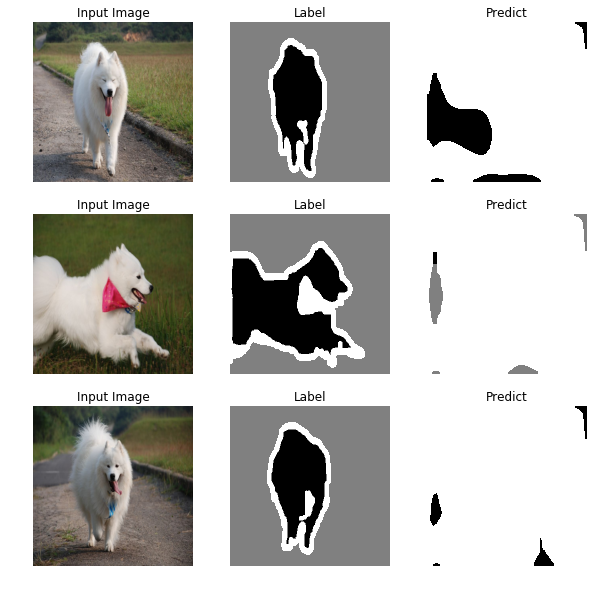

In [ ]:
plt.figure(figsize=(10, 10))

i = 0
mask_idx = 0

with open('./predict.txt', 'r') as f:
    for line in f.readlines():
        image_path, label_path = line.strip().split('\t')
        resize_t = T.Compose([
            T.Resize(IMAGE_SIZE)
        ])
        image = resize_t(PilImage.open(image_path))
        label = resize_t(PilImage.open(label_path))

        image = np.array(image).astype('uint8')
        label = np.array(label).astype('uint8')

        if i > 8: 
            break
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title('Input Image')
        plt.axis("off")

        plt.subplot(3, 3, i + 2)
        plt.imshow(label, cmap='gray')
        plt.title('Label')
        plt.axis("off")
        
        # 模型只有一个输出，所以我们通过predict_results[0]来取出1000个预测的结果
        # 映射原始图片的index来取出预测结果，提取mask进行展示
        data = predict_results[0][mask_idx][0].transpose((1, 2, 0))
        mask = np.argmax(data, axis=-1)

        plt.subplot(3, 3, i + 3)
        plt.imshow(mask.astype('uint8'), cmap='gray')
        plt.title('Predict')
        plt.axis("off")
        i += 3
        mask_idx += 1

plt.show()